### Import libraries

In [55]:
import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils.gridintersect import GridIntersect
import flopy.utils.binaryfile as bf
import os
import flopy.utils.binaryfile as bf
import numpy as np
from osgeo import gdal
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from pathlib import Path

### Create MODFLOW model simulation file

In [56]:
name = "peat_testing_1"
workspace="../testing_peat_module/Model/"

sim = flopy.mf6.MFSimulation(sim_name = name, 
                            sim_ws=workspace)


### Set time discretization 

Set simulation for:
- 10 stress periods
- 5 days of stress period length
- 1 time steps in a stress period
- 1 multiplier length of stress period

In [57]:
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, 
    nper=10,
    time_units="DAYS", 
    perioddata=[[5,1,1] for _ in range(10)]
)

### Set iterative model solver (ims) and gwf package

In [58]:
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", complexity="SIMPLE")
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
model_nam_file = "{}.nam".format(name)

### Create initial condition package

In [59]:
# Initial head
start = 3

ic = flopy.mf6.ModflowGwfic(gwf, pname= "ic", strt=start)

### Read raster input files for grid discretization

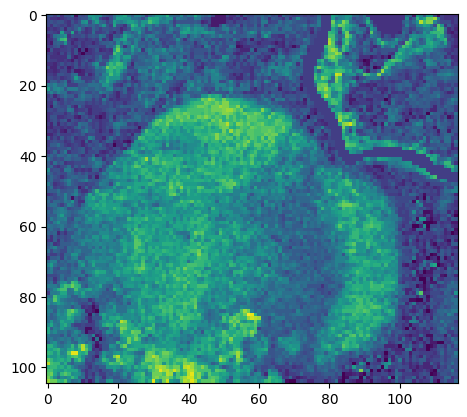

In [60]:
# Raster paths
demPath = "../testing_peat_module/Raster/INA_1sec_srtm_refine_48s_100m_clip.tif"

# Open files
demDs = gdal.Open(demPath)

# Get data as arrays
demData = demDs.GetRasterBand(1).ReadAsArray()

plt.imshow(demData)


### Set grid

In [61]:
# spatial discretization object

# Nlay = 2
Nrow = demDs.RasterXSize
Ncol = demDs.RasterYSize
cell_size = demDs.GetGeoTransform()[1]
ztop = demDs.ReadAsArray()
zbot = np.linspace(-10/1, -10, 1 ) # set constant thickness of 10 units

dis = flopy.mf6.ModflowGwfdis(gwf, nlay=1, nrow=Nrow, ncol=Ncol, delr=cell_size, delc=cell_size,
                              top=ztop, botm=zbot)

# square model with a specified head equal to h1 along the edge of the model in layer 1. 
# A well is located in the center of the upper-left quadrant in layer 10. 
# First, set the name of the model and the parameters of the model: 
# the number of layers Nlay, 
# the number of rows and columns N, 
# lengths of the sides of the model L, 
# aquifer thickness H, hydraulic conductivity k, 
# and the well pumping rate q.

# h1 = 100
# Nlay = 10
# N = 101
# L = 400.0
# H = 50.0
# k = 1.0
# q = -1000.0

# bot = np.linspace(-H / Nlay, -H, Nlay)
# delrow = delcol = L / (N - 1)
# dis = flopy.mf6.ModflowGwfdis(
#     gwf,
#     nlay=Nlay,
#     nrow=N,
#     ncol=N,
#     delr=delrow,
#     delc=delcol,
#     top=0.0,
#     botm=bot,
# )

Ncol

105

### Set hydraulic conductivity (property flow)

In [62]:
# Set hydraulic conductivity value
hk = [1E-6]
# Create node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=1, k=hk, save_flows=True
)

### Add RIV package

In [63]:
# #Add the drain package (DRN) to the MODFLOW model
# river_path = "../testing_peat_module/Raster/Stream_DEMNAS.tif"
# river = gdal.Open(river_path)
# riv_nrow = river.RasterYSize
# riv_ncol = river.RasterXSize
# riv_cellsize = river.GetGeoTransform()[1]

# list = []
# for i in range(riv_nrow):
#     for j in range(riv_ncol):
#         value = river.GetRasterBand(1).ReadAsArray()[i][j]
#         if value != -128:
#             list.append([0, i, j, ztop[i][j], 0.01, "'RIV'"])  # layer, row, column, elevation, conductance

# drn_spd = {0:list}
# drn = flopy.mf6.ModflowGwfriv(gwf,
#     pname="riv",
#     maxbound=len(drn_spd),
#     stress_period_data=drn_spd,
#     save_flows=True)

# drn

### Constant Head package 

In [70]:
# Create the constant head package.
# List information is created a bit differently for
# MODFLOW 6 than for other MODFLOW versions.  The
# cellid (layer, row, column, for a regular grid)
# must be entered as a tuple as the first entry.
# Remember that these must be zero-based indices!
N = 101
h1 = h2 = start
Nlay = 1

chd_rec = []
chd_rec.append(((0, int(N / 4), int (N / 4)), h2))
for layer in range(0, Nlay):
    for row_col in range(0, N):
        chd_rec.append(((layer, row_col, 0), h1))
        chd_rec.append(((layer, row_col, N - 1), h1))
        if row_col != 0 and row_col != N - 1:
            chd_rec.append(((layer, 0, row_col), h1))
            chd_rec.append(((layer, N - 1, row_col), h1))
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
    gwf,
    pname="chd",
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)
chd_rec

[((0, 25, 25), 3),
 ((0, 0, 0), 3),
 ((0, 0, 100), 3),
 ((0, 1, 0), 3),
 ((0, 1, 100), 3),
 ((0, 0, 1), 3),
 ((0, 100, 1), 3),
 ((0, 2, 0), 3),
 ((0, 2, 100), 3),
 ((0, 0, 2), 3),
 ((0, 100, 2), 3),
 ((0, 3, 0), 3),
 ((0, 3, 100), 3),
 ((0, 0, 3), 3),
 ((0, 100, 3), 3),
 ((0, 4, 0), 3),
 ((0, 4, 100), 3),
 ((0, 0, 4), 3),
 ((0, 100, 4), 3),
 ((0, 5, 0), 3),
 ((0, 5, 100), 3),
 ((0, 0, 5), 3),
 ((0, 100, 5), 3),
 ((0, 6, 0), 3),
 ((0, 6, 100), 3),
 ((0, 0, 6), 3),
 ((0, 100, 6), 3),
 ((0, 7, 0), 3),
 ((0, 7, 100), 3),
 ((0, 0, 7), 3),
 ((0, 100, 7), 3),
 ((0, 8, 0), 3),
 ((0, 8, 100), 3),
 ((0, 0, 8), 3),
 ((0, 100, 8), 3),
 ((0, 9, 0), 3),
 ((0, 9, 100), 3),
 ((0, 0, 9), 3),
 ((0, 100, 9), 3),
 ((0, 10, 0), 3),
 ((0, 10, 100), 3),
 ((0, 0, 10), 3),
 ((0, 100, 10), 3),
 ((0, 11, 0), 3),
 ((0, 11, 100), 3),
 ((0, 0, 11), 3),
 ((0, 100, 11), 3),
 ((0, 12, 0), 3),
 ((0, 12, 100), 3),
 ((0, 0, 12), 3),
 ((0, 100, 12), 3),
 ((0, 13, 0), 3),
 ((0, 13, 100), 3),
 ((0, 0, 13), 3),
 ((0, 100, 13

In [65]:
#evapotranspiration package
# evtr = 1.2/365/86400
# evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=ztop,rate=evtr,depth=1.0)

# evt

In [66]:
hname = '{}.hds'.format("peat_testing_1")
cname = '{}.cbc'.format("peat_testing_1")
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
 head_filerecord=hname,
 saverecord=[('HEAD', 'ALL'), ('BUDGET',
'ALL')])

sim.write_simulation()
print(os.listdir(workspace))


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model peat_testing_1...
    writing model name file...
    writing package ic...
    writing package dis...
    writing package npf...
    writing package chd...
    writing package oc...
['archive', 'mfsim.nam', 'peat_testing_1.chd', 'peat_testing_1.dis', 'peat_testing_1.ic', 'peat_testing_1.ims', 'peat_testing_1.nam', 'peat_testing_1.npf', 'peat_testing_1.oc', 'peat_testing_1.tdis']


In [69]:
# Run the simulation
success, buff = sim.run_simulation()
print("\nSuccess is: ", success)

FloPy is using the following executable to run the model: C:\Users\mwidijanto\AppData\Local\flopy\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 10 2022 05:57:01 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither t

### Plot the model result

In [68]:
# #open head file
# hds = bf.HeadFile("../testing_peat_module/Model/peat_testing_1.hds")
# head = hds.get_data(totim=hds.get_times()[-1])
# # head[head==1e+30]=np.nan

# #plot model heads
# fig = plt.figure(figsize=(18, 12))
# ax = fig.add_subplot(1, 1, 1, aspect='equal')
# mapview = flopy.plot.PlotMapView(model=gwf)

# # levels = np.linspace(np.nanmin(head),np.nanmax(head),num=20)
# contour_set = mapview.contour_array(head)
# t = ax.set_title("Model Heads")
# plt.colorbar(contour_set, shrink=0.6)
# plt.show()